# Проект для «Викишоп»

## Постановка задачи
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

## Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Ход работы

## Импорт библиотек и настройки

In [1]:
import pandas as pd
import numpy as np

# Для визуализации
import matplotlib.pyplot as plt

# Для удобства
import time
from tqdm import tqdm, tqdm_notebook

# Модели ML
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Для работы с моделями ML
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

# Для работы с текстом
import torch
import transformers
import spacy
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Устанавливаем настройки отображения
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1. Загрузка данных

In [3]:
try:
    df = pd.read_csv('datasets/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

### Первичный взгляд на данные

In [4]:
df[:15]

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Текст на английском, требует лемматизации и очистки.

In [5]:
df.sample(5)

,Unnamed: 0,text,toxic
82191,82269,Sales Tax Remittance Question \n\nI'm confused...,0
53898,53959,"Capitalization again \n\nDoc,\n\nI've responde...",0
110779,110876,""" Attention:\nThis IP address, , is registered...",0
71876,71946,Mike Church \n\nI see that a new problem edito...,0
144516,144672,Thanks for the comforting reply. I just though...,0


In [6]:
df.tail(15)

,Unnamed: 0,text,toxic
159277,159436,"I'll be on IRC, too, if you have a more specif...",0
159278,159437,It is my opinion that that happens to be off-t...,0
159279,159438,Please stop removing content from Wikipedia; i...,0
159280,159439,Image:Barack-obama-mother.jpg listed for delet...,0
159281,159440,"""Editing of article without Consensus & Remova...",0
159282,159441,"""\nNo he did not, read it again (I would have ...",0
159283,159442,"""\n Auto guides and the motoring press are not...",0
159284,159443,"""\nplease identify what part of BLP applies be...",0
159285,159444,Catalan independentism is the social movement ...,0
159286,159445,The numbers in parentheses are the additional ...,0


Столбец 'Unnamed 0' содержит артефакты, использовать его в качестве индекса нельзя - требуется удалить.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
df_initial_shape = df.shape

In [9]:
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [10]:
# Видим сильные дисбаланс по mean и std, оценим ближе:
print(df.toxic.value_counts(normalize=True))

0    0.898388
1    0.101612
Name: toxic, dtype: float64


Передо мной стоит задача бинарной классификации, значит целевой признак это 0 и 1 в ответе. По среднему, равному 0,1 и сильному отклюнению в 0,3 видно, что между классами виден сильный дисбаланс, что нужно будет учесть при обучении моделей.

In [11]:
df[df.duplicated(keep='first')].count()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [12]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

### Вывод
По первому взгляду на данные можно сделать следующие выводы:

Стиль:
- Подозрительный столбец Unnamed это индекс, причём нечёткий - перед выгрузкой данных были удалены строки без сброса индекса, и сами данные были выгружены некорректно. Этот стобец нельзя использовать в качестве индекса.

Первичная качественная оценка:
- Типы данных в порядке;
- Дубликатов нет;
- Пропусков нет.

Признаки:
- Текст не чистый, требуются лемматизация и очистка;
- Текст на английском;
- Есть дисбаланс классов.

Весь EDA сводится к удалению лишнего столбца, что мы сразу и делаем. С признаками и дисбалансом буду разбираться на этапе подготовки данных к моделированию.

In [13]:
df = df.drop('Unnamed: 0', axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [15]:
df.tail(15)

,text,toxic
159277,"I'll be on IRC, too, if you have a more specif...",0
159278,It is my opinion that that happens to be off-t...,0
159279,Please stop removing content from Wikipedia; i...,0
159280,Image:Barack-obama-mother.jpg listed for delet...,0
159281,"""Editing of article without Consensus & Remova...",0
159282,"""\nNo he did not, read it again (I would have ...",0
159283,"""\n Auto guides and the motoring press are not...",0
159284,"""\nplease identify what part of BLP applies be...",0
159285,Catalan independentism is the social movement ...,0
159286,The numbers in parentheses are the additional ...,0


## 2. Подготовка

### Лемматизация и очистка текста от символов и стоп-слов

Напишу функцию, которая будет лемматизировать на английском и чистить от лишних симолов и операторов.<br>
В этом случае лемматизатор pymystem3 не подходит (он для кириллицы). Хорошими выборами будут WordNetLemmatizer или SpaCy. Беру Spacy - его можно быстрее настроить.

In [16]:
# Инициализируем лемматизатор
lemmatizer = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])

# Подгружаем стоп-слова
spacy_stopwords = lemmatizer.Defaults.stop_words

In [17]:
def lemmings(filthy_text):
    '''
    Функция лемматизации и очистки текста на английском языке. На вход принимает неочищенный текстовый вектор. На выход отдаёт очищенный.
    '''

    clean_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', filthy_text.lower()).split())
    lemmatized = " ".join([token.lemma_ for token in lemmatizer(clean_text)])

    stopped = []
    for token in lemmatized.split():
        if token not in spacy_stopwords:
            stopped.append(token)

    return " ".join(stopped)

In [18]:
# Проверим на небольшом куске датасета
df_lemma_test = df.sample(15)
tqdm.pandas()
df_lemma_test['text_test'] = df_lemma_test['text'].progress_apply(lemmings)
display(df_lemma_test)

del df_lemma_test

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 147.39it/s]


,text,toxic,text_test
154575,"DVD? Are you sure about that? Anyway, while it...",0,dvd sure remain possible don t significant pro...
58320,Sarah Palin's family \n\nWhy (or for that matt...,0,sarah palin s family matter mention bristol pa...
85240,Thrindel is a faggot. \n\nDiscuss Delete.,1,thrindel faggot discuss delete
44543,"""\nWhen you changed name, did someone else reg...",0,change register
63471,No thats not what I am suggesting. They are an...,0,s I suggest illegal organisation illegal terro...
68756,WHY DO YOU THINK TRIVIUM'S MUSIC IS GREA TIDIO...,1,think trivium s music grea tidiot s fucking me...
60398,It would be helpful if you provided a little m...,0,helpful provide little information mean don t ...
14663,DYK nomination of Salt surface structures\n He...,0,dyk nomination salt surface structure hello su...
151615,"Yes, the form is very 'modern', at least the w...",0,yes form modern way guy translate daniel ladin...
13503,/b/ random. \n\nThen I will feed them to you.,0,b random I feed


Функция отрабатывает нормально, можно применять к датасету.

In [19]:
# Применим функцию к данным
tqdm.pandas()
df['text_lemmy'] = df['text'].progress_apply(lemmings)

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [13:45<00:00, 192.95it/s]


In [20]:
df[:5]

,text,toxic,text_lemmy
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d aww match background colour I m seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m try edit war s guy constantly remo...
3,"""\nMore\nI can't make any real suggestions on ...",0,I t real suggestion improvement I wonder secti...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page s


In [21]:
df.sample(5)

,text,toxic,text_lemmy
77653,"""Hello, ! Thank you so much for taking part in...",0,hello thank universitas workshop ve learn basi...
41858,"So finally, Wikipedia's ultimate weapon is whe...",0,finally wikipedia s ultimate weapon wheel sile...
90165,The following pages should be deleted they do ...,0,follow page delete meet wikipedia crtieria gre...
48176,WP:Hornbook a new law-related task force for ...,0,wp hornbook new law relate task force j d curr...
139765,Oh not you again!!! And so? After the block ha...,1,oh block expire I m kick gwerns ass admin wann...


In [22]:
df.isna().sum()

text          0
toxic         0
text_lemmy    0
dtype: int64

In [23]:
# Удалим неочищенный столбец и сразу проверим.
df = df.drop('text', axis=1)

In [24]:
df[:5]

,toxic,text_lemmy
0,0,explanation edit username hardcore metallica f...
1,0,d aww match background colour I m seemingly st...
2,0,hey man I m try edit war s guy constantly remo...
3,0,I t real suggestion improvement I wonder secti...
4,0,sir hero chance remember page s


In [25]:
df.sample(5)

,toxic,text_lemmy
150735,0,people simply disappear night remove register ...
21321,0,award portugese barnstar diligence eden tate t...
139105,0,criticism persecution prosecution new write ed...
155186,0,welcome hello jay welcome wikipedia thank cont...
83634,0,redirect talk indian labour law


In [26]:
df.isna().sum()

toxic         0
text_lemmy    0
dtype: int64

Лемматизация и чистка проведены.

## 3. Обучение
Обучим модели:
1. LogisticRegression
2. LGBMRegressor
3. CatBoostRegressor

В моём распоряжении довольно приличное количество данных, поэтому для обучения можно выделить данных побольше - возьмём 9:1, а кроссвалидатору указываю 9 подвыборок.<br>
Для борьбы с дисбалансом классов делаю стратификацию при делении на выборки. Также выбираю взвешивание весов, т.к. дисбаланс очень большой. Не буду применять техники сэмлирования, т.к. во-первых это даст более низкую точность моделей (либо слишком много полезного вырежется, либо слишком много шума добавлено), а во-вторых это долго.<br>
Обучение пройдёт через pipeline, поэтому для чистоты кода в блоке обучения напишу функцию обучения моделей с GridSearch.

### Выборки

In [27]:
# Выделаям целевой признак
X = df['text_lemmy']
y = df['toxic']

# Учитвыая дисбаланс классов, укажем целевой признак для стратификации
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    stratify = y,
                                                    random_state = 55555)

In [28]:
# Проверяем
display(X_train.head())
display(y_train.head())

131685    information unreliable consider authoritative ...
20837                        I rephrase mention player talk
107565    october utc religious information remove histo...
48226     fine I wait watch I skeptical wait half year p...
94627     correct life life error slip lip like I long a...
Name: text_lemmy, dtype: object

131685    0
20837     0
107565    0
48226     0
94627     0
Name: toxic, dtype: int64

In [29]:
print('Контроль размерности выборок - (признаки) и (целевой признак)')
print(f'Тренировочная выборка: {X_train.shape} и {y_train.shape}')
print(f'Тестовая выборка: {X_test.shape} и {y_test.shape}')
print(f'\nДоли от датасета')
print(f'Тренировочная выборка:\t{len(X_train)/len(df):.2%}')
print(f'Тестовая выборка:\t{len(X_test)/len(df):.2%}')

Контроль размерности выборок - (признаки) и (целевой признак)
Тренировочная выборка: (143362,) и (143362,)
Тестовая выборка: (15930,) и (15930,)

Доли от датасета
Тренировочная выборка:	90.00%
Тестовая выборка:	10.00%


### Настройки обучения
Функция для обучения:

In [30]:
def model_fitting(piped, param_grid, n, X, y):
    '''
    Функция обучения модели кроссвалидацей GridSearch в pipeline. На вход принимает
        piped - инициализированный пайплайн
        param_grid - сетка параметров пайплайна
        n - количество подвыборок для кросс-валидации
        X - признаки
        y - целевой признак

    На выход отдаёт обученную модель.
    '''
    model = GridSearchCV(piped,
                         param_grid = param_grid,
                         scoring = 'f1',
                         cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 55555),
                         return_train_score = True)
    model.fit(X, y)

    return model

### 3.1 LogReg

In [31]:
# Инициализируем пайплайн
pipe_logreg = make_pipeline(TfidfVectorizer(),
                            LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=55555)) #, solver='saga', penalty='elasticnet'

# Параметры для пайплайна
param_logreg = [{'tfidfvectorizer__max_df':[0.1, 0.3, 0.5],
                 'logisticregression__C':[0.1, 1, 10, 50]}]#,
                 # 'logisticregression__l1_ratio':np.arange(0.0, 1.1, 0.5)}]

In [32]:
%%time

# Обучим модель и засечём время
fit_start = time.time()
model_logreg = model_fitting(pipe_logreg, param_logreg, 5, X_train, y_train)
fit_end = time.time()

CPU times: total: 6min 52s
Wall time: 10min 52s


In [33]:
# Соберём данные для визуализации
total_fit_time_logreg = fit_end - fit_start
mean_fit_time_logreg = model_logreg.cv_results_['mean_fit_time'].mean()
mean_score_time_logreg = model_logreg.cv_results_['mean_score_time'].mean()
best_score_logreg = abs(model_logreg.best_score_)
n_models_logreg = 5*len(model_logreg.cv_results_['params'])

results_logreg = [best_score_logreg,
                  mean_fit_time_logreg,
                  mean_score_time_logreg,
                  n_models_logreg,
                  total_fit_time_logreg]

#### Результат

In [34]:
print(f'Лучший результат F1: {results_logreg[0]}')
print(f'Среднее время обучения: {results_logreg[1]} с')
print(f'Среднее время предсказания: {results_logreg[2]} с')
print(f'Количество обученных моделей: {results_logreg[3]}')
print(f'Общее время обучения на GridSearchCV с 5 фолдами: {results_logreg[4]} с')
display(model_logreg.best_params_)

Лучший результат F1: 0.7641422028934995
Среднее время обучения: 7.061787962913512 с
Среднее время предсказания: 0.7285221099853515 с
Количество обученных моделей: 60
Общее время обучения на GridSearchCV с 5 фолдами: 652.9137034416199 с


{'logisticregression__C': 10, 'tfidfvectorizer__max_df': 0.3}

### 3.2 LGBMClassifier

In [35]:
# Инициализируем пайплайн
pipe_lgbm = make_pipeline(TfidfVectorizer(),
                          LGBMClassifier(class_weight = 'balanced', learning_rate = 0.1, random_state = 55555))

# Параметры для пайплайна
param_lgbm = [{'tfidfvectorizer__max_df': [0.1, 0.3, 0.5],
               'lgbmclassifier__n_estimators' : range(11, 21, 2) }]

In [36]:
%%time

# Обучим модель и засечём время
fit_start = time.time()
model_lgbm = model_fitting(pipe_lgbm, param_lgbm, 5, X_train, y_train)
fit_end = time.time()

CPU times: total: 1h 41min 21s
Wall time: 23min 31s


In [37]:
# Соберём данные для визуализации
results_lgbm = [abs(model_lgbm.best_score_),
                model_lgbm.cv_results_['mean_fit_time'].mean(),
                model_lgbm.cv_results_['mean_score_time'].mean(),
                5*len(model_lgbm.cv_results_['params']),
                fit_end - fit_start]

#### Результат

In [38]:
print(f'Лучший результат F1: {results_lgbm[0]}')
print(f'Среднее время обучения: {results_lgbm[1]} с')
print(f'Среднее время предсказания: {results_lgbm[2]} с')
print(f'Количество обученных моделей: {results_lgbm[3]}')
print(f'Общее время обучения на GridSearchCV с 5 фолдами: {results_lgbm[4]} с')
display(model_lgbm.best_params_)

Лучший результат F1: 0.7078504025139473
Среднее время обучения: 13.715851586659749 с
Среднее время предсказания: 1.066257988611857 с
Количество обученных моделей: 75
Общее время обучения на GridSearchCV с 5 фолдами: 1411.2124729156494 с


{'lgbmclassifier__n_estimators': 17, 'tfidfvectorizer__max_df': 0.1}

### 3.3 CatBoostClassifier

In [39]:
# Инициализируем пайплайн
pipe_catboost = make_pipeline(TfidfVectorizer(),
                              CatBoostClassifier(auto_class_weights = 'Balanced', random_state = 55555, verbose=False))

# Параметры для пайплайна
param_catboost = [{'tfidfvectorizer__max_df': [0.1, 0.3, 0.5],
                   'catboostclassifier__iterations' : [100]}]

In [40]:
%%time

# Обучим модель и засечём время
fit_start = time.time()
model_catboost = model_fitting(pipe_catboost, param_catboost, 5, X_train, y_train)
fit_end = time.time()

CPU times: total: 3h 34min 41s
Wall time: 43min 53s


In [41]:
# Соберём данные для визуализации
results_catboost = [abs(model_catboost.best_score_),
                    model_catboost.cv_results_['mean_fit_time'].mean(),
                    model_catboost.cv_results_['mean_score_time'].mean(),
                    5*len(model_catboost.cv_results_['params'])*50,
                    fit_end - fit_start]

#### Результат

In [42]:
print(f'Лучший результат F1: {results_catboost[0]}')
print(f'Среднее время обучения: {results_catboost[1]} с')
print(f'Среднее время предсказания: {results_catboost[2]} с')
print(f'Количество обученных моделей: {results_catboost[3]}')
print(f'Общее время обучения на GridSearchCV с 5 фолдами: {results_catboost[4]} с')
display(model_catboost.best_params_)

Лучший результат F1: 0.7395808035717231
Среднее время обучения: 157.30417178471885 с
Среднее время предсказания: 1.6271150271097818 с
Количество обученных моделей: 750
Общее время обучения на GridSearchCV с 5 фолдами: 2633.0681080818176 с


{'catboostclassifier__iterations': 100, 'tfidfvectorizer__max_df': 0.1}

### Сравнение моделей

In [43]:
# Сводим все интересующие нас результаты в одну таблицу.
df_train_results = pd.DataFrame(data = [results_logreg,
                                        results_lgbm,
                                        results_catboost],
                                index = ['LogReg',
                                         'LGBM',
                                         'CatBoost'],
                                columns = ['F1_score',
                                           'mean_fit_time',
                                           'mean_score_time',
                                           'n_models',
                                           'total_fit_time'])

df_train_results

,F1_score,mean_fit_time,mean_score_time,n_models,total_fit_time
LogReg,0.764142,7.061788,0.728522,60,652.913703
LGBM,0.707850,13.715852,1.066258,75,1411.212473
CatBoost,0.739581,157.304172,1.627115,750,2633.068108


На обучающей выборке с кросс-валидацией лучший результат дала логистическая регрессия, её метрика F1 составила 0,764, что с натяжкой превышает заданный порог 0,75. Ожидается, что тестовую выборку она так не вытянет.<br>

### Тестирование
Протестирую лучшую модель из этапе обучения на тестовой выборке:

In [44]:
f1_test = f1_score(y_test, model_logreg.predict(X_test))
f1_test

0.7756138865368332

Вопреки опасениям, модель отвечает заданному требованию метрики F1 в 0,776. Но результат оказался выше кроссвалидационного, значит предположительно имеет место некоторое переобучение.  
Оценю на метрику ROC-AUC:

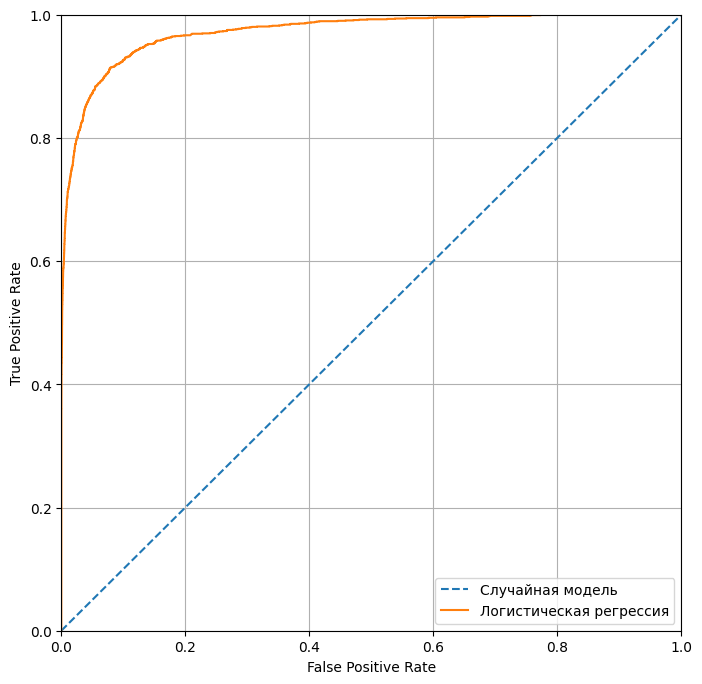

In [46]:
plt.figure(figsize=[8,8])

probs_test = model_logreg.predict_proba(X_test)
probs_one_test = probs_test[:, 1]
fpr, tpr, thr = roc_curve(y_test, probs_one_test)
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
plt.plot(fpr, tpr, label='Логистическая регрессия')

plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

plt.show()

In [47]:
best_roc_auc = roc_auc_score(y_test, probs_one_test)
best_roc_auc

0.972225393295991

ROC-AUC 0,97 и график впечатляют, но откровенно говоря, я им не сильно верю, метрика F1 0,76-0,77 мне больше говорит о возможностях обученной модели, т.к. комбинирует точность и полноту. Для определения токсичности текста точность 0,75 это, на мой взгляд, весьма невысокий показатель, требуется более глубокая проработка задачи на более гибких моделях и на более мощном железе.

## Выводы

Модели на основе CatBoost и LGBM могут быть обучены на очень высокий уровень распознавания текста, однако для этого требуются хорошие вычислительные мощности, тогда как "привычная" логистическая регрессия даёт приемлемый результат для оперативных задач на обычном ноутбуке. Но возможно ли вытянуть её на большие метрики? Это вопрос более подробного исследования.